<a href="https://colab.research.google.com/github/Gui-Felix101/Atividade-LEA/blob/main/notebook_mercado_livre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizando do requests para coletar informações de notebooks do Mercado Livre

## Bibliotecas utilizadas

In [1]:
import requests
import json
from bs4 import BeautifulSoup
import os

## Estudando a estrutura do HTML

In [2]:
url_base = "https://lista.mercadolivre.com.br/"
produto = "notebook"
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}
response = requests.get(f"{url_base}{produto}", headers=headers)
response.raise_for_status()
soup = BeautifulSoup(response.text, 'html.parser')
soup


<!DOCTYPE html>

<html lang="pt-BR">
<head><link href="https://www.google-analytics.com" rel="preconnect"/><link href="https://www.google.com" rel="preconnect"/><link href="https://data.mercadolibre.com" rel="preconnect"/><link href="https://http2.mlstatic.com" rel="preconnect"/><link href="https://stats.g.doubleclick.net" rel="preconnect"/><link href="https://analytics.mercadolivre.com.br" rel="preconnect"/><link href="https://analytics.mercadolivre.com" rel="preconnect"/><link href="https://www.google.com.br" rel="preconnect"/><script nonce="u4KWg/NxZE/dsE9EUB1TCQ==" type="text/javascript">window.NREUM||(NREUM={});NREUM.info = {"agent":"","beacon":"bam.nr-data.net","errorBeacon":"bam.nr-data.net","licenseKey":"NRBR-8547a290c864571ffcc","applicationID":"1729522169","agentToken":null,"applicationTime":796.522571,"transactionName":"bgQDMEcFXkJZBkYNWldOJBxFFlVCSw9BS3J8NU5LHw==","queueTime":0,"ttGuid":"3598fe9f3fdc3666"}; (window.NREUM||(NREUM={})).init={privacy:{cookies_enabled:true},aj

No site do Mercado Livre, o HTML tem uma estrutura fácil e intuitiva, eles possuem funções que utilizam para formar o HTML e no final há um json com as informações úteis para gente. Utilizaremos apenas algumas escolhidas a dedo.

## Coletando a informação

In [4]:
json_script = soup.find("script", type="application/ld+json")
data = json.loads(json_script.string)
for item in data["@graph"]:
    if item["@type"] == "Product":
        titulo = item.get("name", "Título não encontrado")
        preco = item.get("offers", {}).get("price", "Preço não encontrado")
        link = item.get("offers", {}).get("url", "Link não encontrado")
        marca = item.get("brand", {}).get("name", "Marca não encontrada")
        avaliacao = item.get("aggregateRating", {}).get("ratingValue", "Nota não encontrada")
        quantidade_avaliacoes = item.get("aggregateRating", {}).get("ratingCount", "Avaliações não encontradas")
        break
print(f"Título: {titulo}\nPreço: {preco}\nLink: {link}\nMarca: {marca}\nNota: {avaliacao}\nQuantidade de Avaliações: {quantidade_avaliacoes}\n")

Título: Notebook Samsung Galaxy Book Go Np340xla-k06br Snapdragon 4gb 128gb Ssd Ufs Windows 11 Home
Preço: 1897.9
Link: https://www.mercadolivre.com.br/notebook-samsung-galaxy-book-go-np340xla-k06br-snapdragon-4gb-128gb-ssd-ufs-windows-11-home/p/MLB27956758#wid=MLB4541094522&sid=search
Marca: Samsung
Nota: 4.7
Quantidade de Avaliações: 229



É bem simples coletar a informação nesse site, porém, há problemas que podemos encontrar no meio do caminho, como por exemplo, paginação:

In [6]:
produtos = []
data = json.loads(json_script.string)
for item in data["@graph"]:
    if item["@type"] == "Product":
        titulo = item.get("name", "Título não encontrado")
        preco = item.get("offers", {}).get("price", "Preço não encontrado")
        link = item.get("offers", {}).get("url", "Link não encontrado")
        marca = item.get("brand", {}).get("name", "Marca não encontrada")
        avaliacao = item.get("aggregateRating", {}).get("ratingValue", "Nota não encontrada")
        quantidade_avaliacoes = item.get("aggregateRating", {}).get("ratingCount", "Avaliações não encontradas")
        produtos.append({
            "titulo": titulo,
            "preco": preco,
            "link": link,
            "marca": marca,
            "nota": avaliacao,
            "quantidade_avaliacoes": quantidade_avaliacoes
        })
print(produtos)
print(len(produtos))

[{'titulo': 'Notebook Samsung Galaxy Book Go Np340xla-k06br Snapdragon 4gb 128gb Ssd Ufs Windows 11 Home', 'preco': 1897.9, 'link': 'https://www.mercadolivre.com.br/notebook-samsung-galaxy-book-go-np340xla-k06br-snapdragon-4gb-128gb-ssd-ufs-windows-11-home/p/MLB27956758#wid=MLB4541094522&sid=search', 'marca': 'Samsung', 'nota': 4.7, 'quantidade_avaliacoes': 229}, {'titulo': "Notebook Gamer Acer Nitro V Anv15-51-57ws Intel® Core I5-13420h 13ªgeração 512ssd 8gb Nvidia® Geforce® Rtx 3050 Gddr6 Linux Gutta 15,6'", 'preco': 4937, 'link': 'https://www.mercadolivre.com.br/notebook-gamer-acer-nitro-v-anv15-51-57ws-intel-core-i5-13420h-13geraco-512ssd-8gb-nvidia-geforce-rtx-3050-gddr6-linux-gutta-156/p/MLB37396835#wid=MLB5236085492&sid=search', 'marca': 'Acer', 'nota': 'Nota não encontrada', 'quantidade_avaliacoes': 'Avaliações não encontradas'}, {'titulo': 'Notebook Gamer Lenovo Loq 15irh8 Intel Core I5 12450h 16gb Ram 512gb Ssd Rtx 2050 Windows 11 Home Tela 15,6 Full Hd 83eu0001br', 'preco': 

Como o site do Mercado Livre trabalha com páginas de até 48 produtos numa pesquisa, logo, precisamos fazer a paginação de forma que encontremos os próximos 48 produtos pesquisados.

In [8]:
total_produtos = 500
produtos_coletados = 0
pagina = 1

if not os.path.exists("data"):
    os.makedirs("data")

while produtos_coletados < total_produtos:
    offset = (pagina - 1) * 48 #offset é a marcação do mercado livre para mostrar itens após esse produto
    url = f"{url_base}{produto}#menu=categories&offset={offset}"
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    soup = BeautifulSoup(response.text, 'html.parser')

    json_script = soup.find("script", type="application/ld+json")

    data = json.loads(json_script.string)
    for item in data["@graph"]:
        if item["@type"] == "Product":
            titulo = item.get("name", "Título não encontrado")
            preco = item.get("offers", {}).get("price", "Preço não encontrado")
            link = item.get("offers", {}).get("url", "Link não encontrado")
            marca = item.get("brand", {}).get("name", "Marca não encontrada")
            avaliacao = item.get("aggregateRating", {}).get("ratingValue", "Nota não encontrada")
            quantidade_avaliacoes = item.get("aggregateRating", {}).get("ratingCount", "Avaliações não encontradas")
            produtos_coletados += 1
            filename = f"data/notebook_{produtos_coletados:03}.json" #definir onde salvar os arquivos (feito no colab)
            with open(filename, "w", encoding="utf-8") as f:
                json.dump({
                    "titulo": titulo,
                    "preco": preco,
                    "link": link,
                    "marca": marca,
                    "nota": avaliacao,
                    "quantidade_avaliacoes": quantidade_avaliacoes
                }, f, indent=4, ensure_ascii=False)
            if produtos_coletados >= total_produtos:
                break

# Análise Estatística

## Análise descritiva

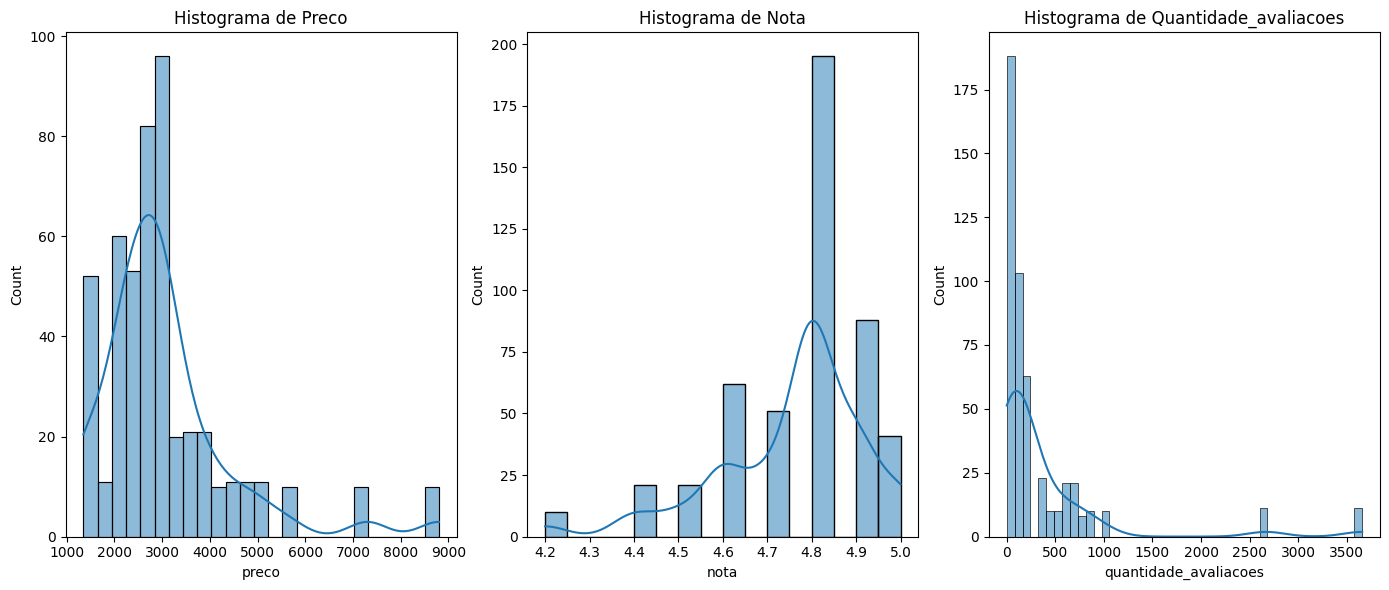

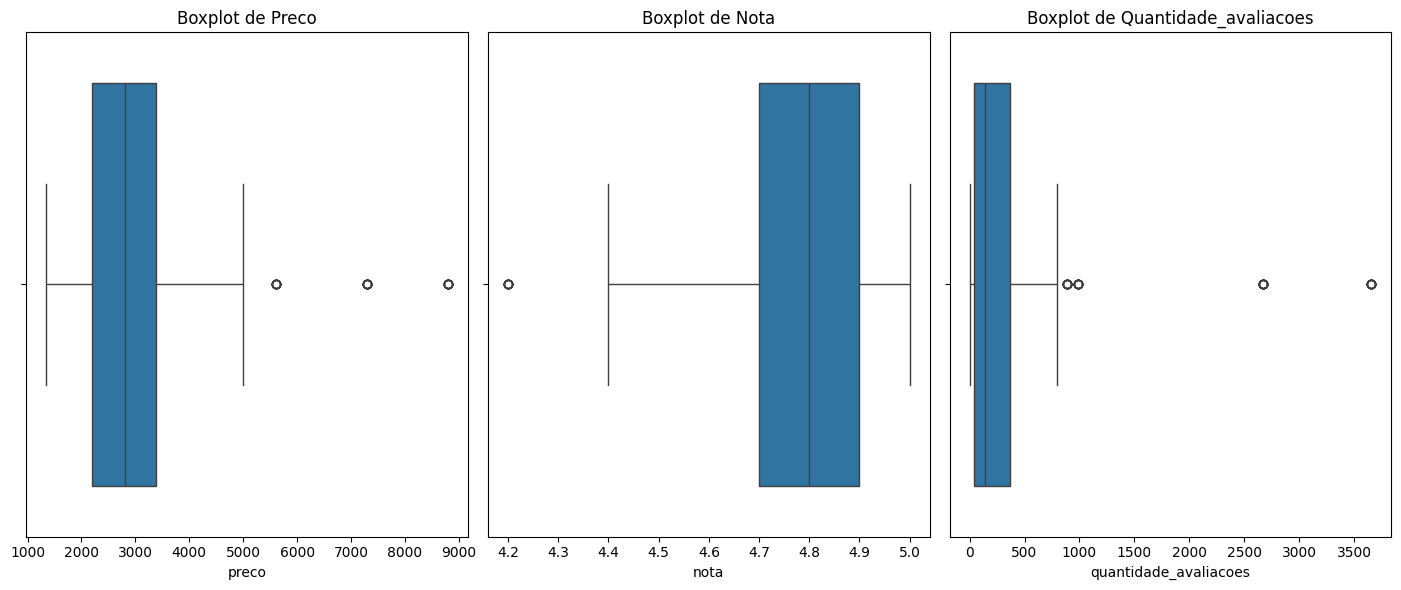

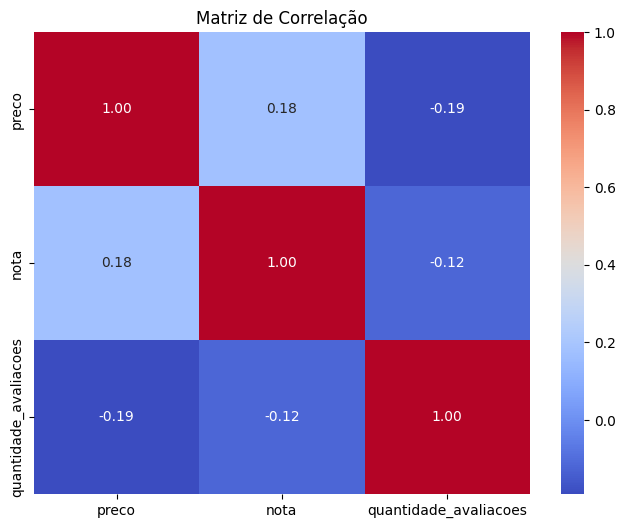

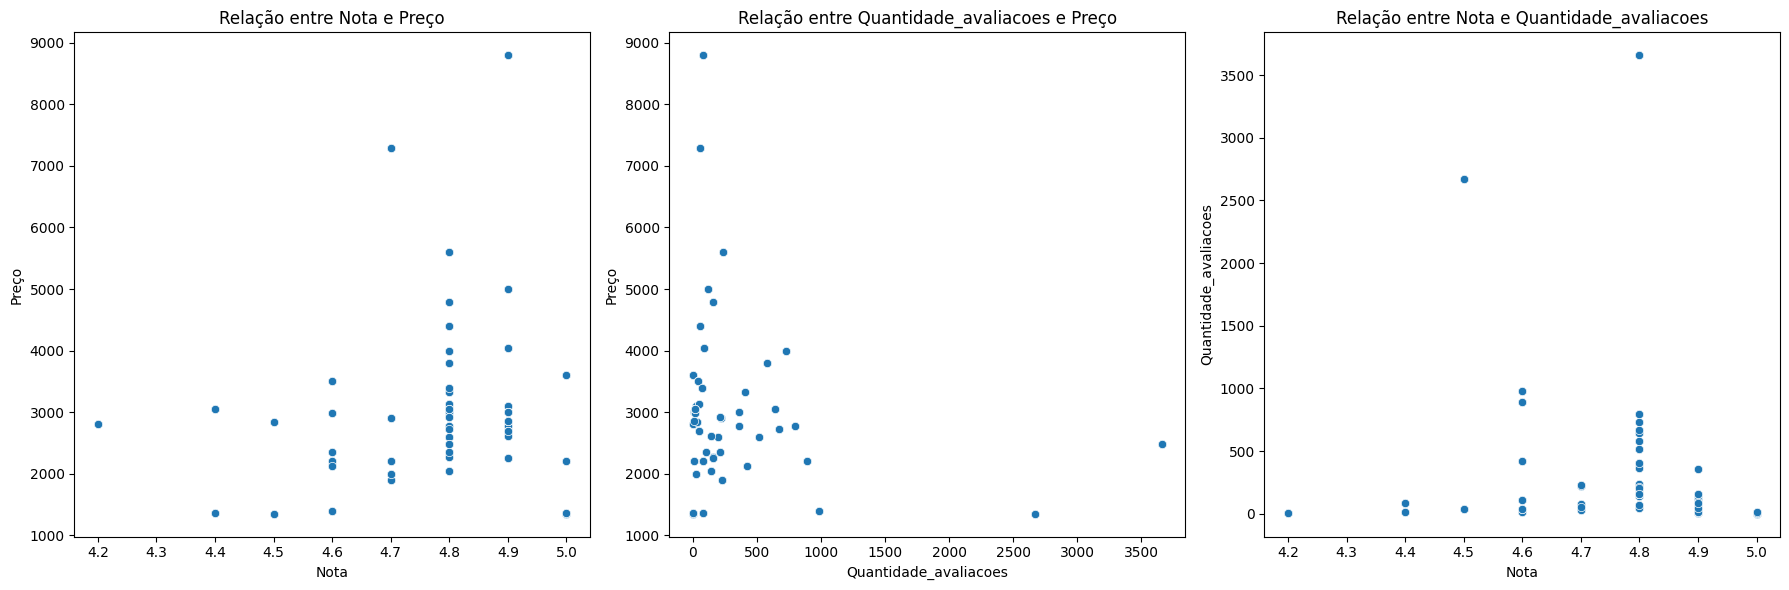

             preco        nota  quantidade_avaliacoes
count   489.000000  489.000000             489.000000
mean   3049.561922    4.756646             352.985685
std    1399.699138    0.165960             668.941173
min    1349.000000    4.200000               1.000000
25%    2199.000000    4.700000              40.000000
50%    2799.000000    4.800000             139.000000
75%    3383.940000    4.900000             364.000000
max    8799.000000    5.000000            3658.000000


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

json_files = glob.glob(os.path.join("data", "notebook_*.json"))

data_list = []


for file in json_files:
    with open(file, "r", encoding="utf-8") as f:
        data_list.append(json.load(f))


df = pd.DataFrame(data_list)
df['preco'] = pd.to_numeric(df['preco'], errors='coerce')
df['nota'] = pd.to_numeric(df['nota'], errors='coerce')
df['quantidade_avaliacoes'] = pd.to_numeric(df['quantidade_avaliacoes'], errors='coerce')
df_cleaned = df.dropna(subset=['preco', 'nota', 'quantidade_avaliacoes'])

#medidas descritivas
description = df_cleaned.describe()

#histogramas
plt.figure(figsize=(14, 6))
for i, col in enumerate(['preco', 'nota', 'quantidade_avaliacoes'], 1):
    plt.subplot(1, 3, i)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f"Histograma de {col.capitalize()}")
plt.tight_layout()
plt.show()

#boxplots
plt.figure(figsize=(14, 6))
for i, col in enumerate(['preco', 'nota', 'quantidade_avaliacoes'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f"Boxplot de {col.capitalize()}")
plt.tight_layout()
plt.show()

#correlacao
correlation_matrix = df_cleaned[['preco', 'nota', 'quantidade_avaliacoes']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

plt.figure(figsize=(18, 6))
for i, col in enumerate(['nota', 'quantidade_avaliacoes'], 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df_cleaned[col], y=df_cleaned['preco'])
    plt.title(f"Relação entre {col.capitalize()} e Preço")
    plt.xlabel(col.capitalize())
    plt.ylabel('Preço')
plt.subplot(1,3,3)
sns.scatterplot(x=df_cleaned['nota'], y=df_cleaned['quantidade_avaliacoes'])
plt.title("Relação entre Nota e Quantidade_avaliacoes")
plt.xlabel('Nota')
plt.ylabel('Quantidade_avaliacoes')
plt.tight_layout()
plt.show()

# Exibir descrição estatística
print(description)

<ipython-input-20-d69221a9cd61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='marca', y=col, data=df_cleaned, palette="Set3")
<ipython-input-20-d69221a9cd61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='marca', y=col, data=df_cleaned, palette="Set3")
<ipython-input-20-d69221a9cd61>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='marca', y=col, data=df_cleaned, palette="Set3")


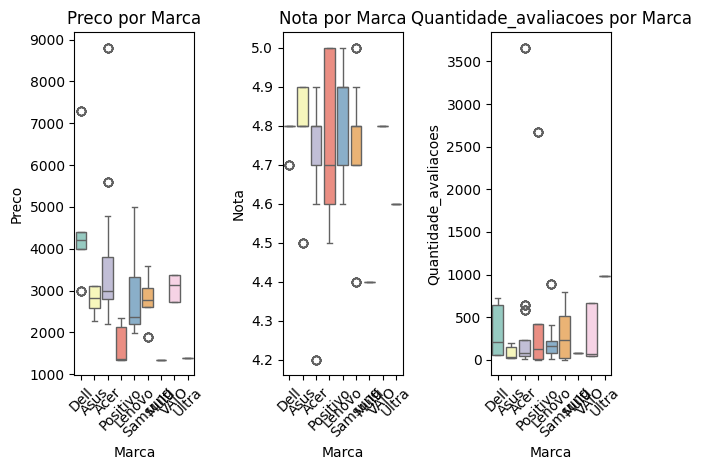

In [20]:
for i, col in enumerate(['preco', 'nota', 'quantidade_avaliacoes'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='marca', y=col, data=df_cleaned, palette="Set3")
    plt.title(f"{col.capitalize()} por Marca")
    plt.xticks(rotation=45)
    plt.xlabel("Marca")
    plt.ylabel(col.capitalize())
plt.tight_layout()
plt.show()

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 11553427.0000 - mae: 3062.3984 - val_loss: 11505352.0000 - val_mae: 3080.0425
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11511023.0000 - mae: 3073.6465 - val_loss: 11483474.0000 - val_mae: 3076.3455
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10252536.0000 - mae: 2908.9893 - val_loss: 11424952.0000 - val_mae: 3066.5425
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11610678.0000 - mae: 3095.5454 - val_loss: 11280812.0000 - val_mae: 3042.5696
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11514344.0000 - mae: 3070.1448 - val_loss: 10979920.0000 - val_mae: 2992.2844
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10301820.0000 - mae: 2907.6021 - val_loss: 10414462.0000 - val_mae: 2896.4216
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9559774.0000 - mae: 2784.7681 - val_loss: 9450679.0000 - val_mae: 2726.6699
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

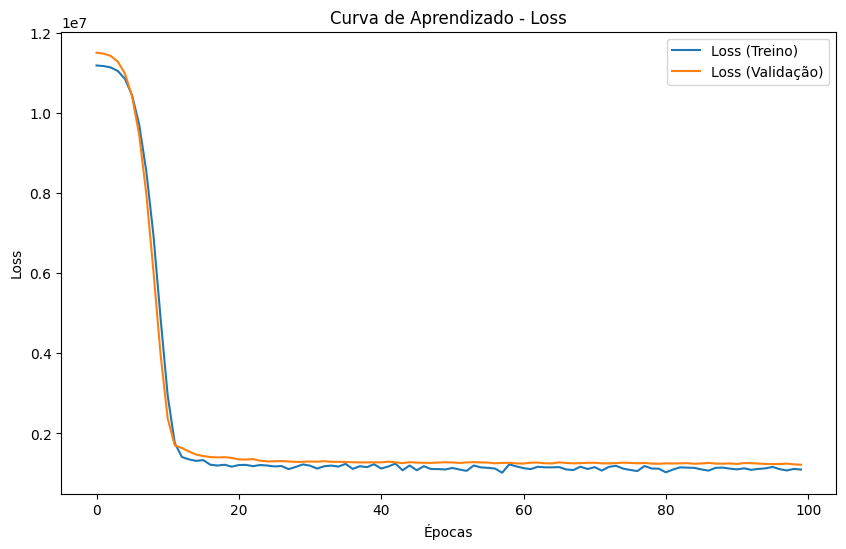

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


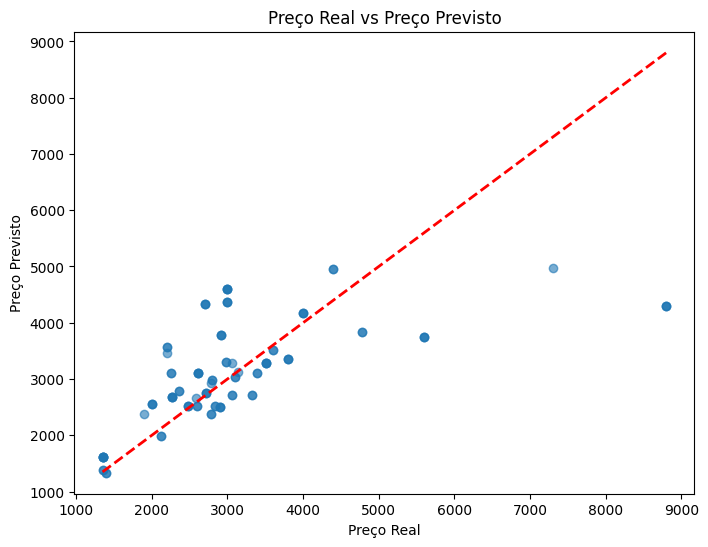

In [22]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, drop='first')
marca_encoded = encoder.fit_transform(df_cleaned[['marca']])
marca_encoded_df = pd.DataFrame(marca_encoded, columns=encoder.get_feature_names_out(['marca']))
df_encoded = pd.concat([df_cleaned.reset_index(drop=True), marca_encoded_df], axis=1)


X = df_encoded[['nota', 'quantidade_avaliacoes'] + list(marca_encoded_df.columns)]
y = df_encoded['preco']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear') #saida para fazer uma reg linear
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)

print(mae)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Loss (Treino)')
plt.plot(history.history['val_loss'], label='Loss (Validação)')
plt.title('Curva de Aprendizado - Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_test_scaled)


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Preço Real vs Preço Previsto')
plt.xlabel('Preço Real')
plt.ylabel('Preço Previsto')
plt.show()